This script processes the clustering results derived from the **scMIXE** embeddings and the single-cell RNA-seq dataset of [Bassez et al. (2021)](https://lambrechtslab.sites.vib.be/en/single-cell) to construct bulk gene-expression matrices for predicting response to anti-PD-1 treatment. The identified marker genes were then evaluated for predictive performance using an independent cohort receiving the same treatment, namely the [I-SPY2 trial (2020)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194040) bulk gene-expression dataset.

The code was executed on a high-RAM CPU runtime (Google Colab Pro).

# Filter marker genes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/scMIXE_clusters_markers.csv'

df = pd.read_csv(file_path)

df.head()

,cluster,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene,predicted_cell_type
0,0,0.0,1.311178,0.538,0.328,0.0,PTPRC,T_cells
1,0,0.0,1.111269,0.423,0.224,0.0,CD2,T_cells
2,0,0.0,1.064695,0.403,0.226,0.0,CD69,T_cells
3,0,0.0,1.035294,0.616,0.439,0.0,EVL,T_cells
4,0,0.0,1.409021,0.450,0.275,0.0,KIAA1551,T_cells


Filter top 50 markers per cluster: filter genes where pct.1 - pct.2 > 0.2 (i.e., at least 20% higher expression frequency in the target cluster)

In [ ]:
df["pct_diff"] = df["pct.1"] - df["pct.2"]

filtered_df = df[df["pct_diff"] > 0.2]

filtered_df = filtered_df.sort_values(by=["cluster", "avg_log2FC"], ascending=[True, False])

top_50_per_cluster = filtered_df.groupby("cluster").head(50)

top_50_per_cluster.head()

,cluster,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene,predicted_cell_type,pct_diff
0,0,0.0,1.311178,0.538,0.328,0.0,PTPRC,T_cells,0.210
2632,2,0.0,3.309493,0.779,0.378,0.0,MGP,Epithelial_cells,0.401
2638,2,0.0,2.801034,0.298,0.078,0.0,SLPI,Epithelial_cells,0.220
2634,2,0.0,2.592208,0.504,0.225,0.0,CD24,Epithelial_cells,0.279
2635,2,0.0,2.363775,0.416,0.149,0.0,MGST1,Epithelial_cells,0.267


In [ ]:
output_path = "/content/drive/My Drive/top_50_markers_per_cluster.csv"
top_50_per_cluster.to_csv(output_path, index=False)

print(f"Saved filtered markers to: {output_path}")

Saved filtered markers to: /content/drive/My Drive/top_50_markers_per_cluster.csv


In [ ]:
!pip install rpy2 pyreadr scipy

import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import pandas as pd
import numpy as np
import scipy.sparse as sp
from rpy2.robjects import r

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.3/418.3 kB 6.0 MB/s eta 0:00:00


# Add cluster-derived cell types to the cell-by-gene matrix

This section imports the sparse cell-by-gene matrix stored in `.rds` format, converts it to a Python-compatible sparse matrix, and appends cluster assignments as an additional row.

In [ ]:
file_path_1 = '/content/drive/cell_gene_matrix.rds'

In [ ]:
r_code = f"""
library(Matrix)
data <- readRDS("{file_path_1}")
data
"""
sparse_matrix = r(r_code)

In [ ]:
r_code = """
library(Matrix)
i <- data@i
p <- data@p
x <- data@x
Dim <- data@Dim
list(i=i, p=p, x=x, Dim=Dim)
"""
s4_slots = r(r_code)

In [ ]:
import numpy as np
from scipy.sparse import csc_matrix

i = np.array(s4_slots[0])
p = np.array(s4_slots[1])
x = np.array(s4_slots[2])
Dim = tuple(s4_slots[3])

In [ ]:
sparse_matrix_python = csc_matrix((x, i, p), shape=Dim)

print(sparse_matrix_python.shape)
print(sparse_matrix_python.nnz, "nonzero elements")

(25291, 157760)
279225777 nonzero elements


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import vstack, csr_matrix

cluster_file_path = '/content/drive/My Drive/bassez_clusters.csv'
cluster_df = pd.read_csv(cluster_file_path)

cluster_values = cluster_df["Cluster"].values.reshape(1, -1)

In [ ]:
cluster_sparse_row = csr_matrix(cluster_values)

print(cluster_sparse_row.shape)

(1, 157760)


In [ ]:
updated_sparse_matrix = vstack([sparse_matrix_python, cluster_sparse_row])

print(updated_sparse_matrix.shape)

(25292, 157760)


In [ ]:
sparse_matrix_python = updated_sparse_matrix

# Find the Gene name index for top 50 markers

The top 50 marker genes are mapped to their corresponding indices in the full gene list to prepare cell-type-specific feature matrices for downstream modeling.

In [ ]:
import numpy as np
import scipy.sparse as sp
import pandas as pd

sparse_matrix_python = sparse_matrix_python.tocsr()

pCR = sparse_matrix_python[-4, :].toarray().flatten()
patient_ids = sparse_matrix_python[-2, :].toarray().flatten()
cell_types = sparse_matrix_python[-1, :].toarray().flatten()

gene_expression_matrix = sparse_matrix_python[:-4, :]

In [ ]:
unique_cell_types = np.unique(cell_types)
unique_patients = np.unique(patient_ids)

bulk_expression_per_cell_type = {}

for cell_type in unique_cell_types:
    cell_indices = np.where(cell_types == cell_type)[0]

    cell_type_matrix = gene_expression_matrix[:, cell_indices]
    patient_subset = patient_ids[cell_indices]

    patient_gene_expression = []

    for patient in unique_patients:
        patient_indices = np.where(patient_subset == patient)[0]

        if len(patient_indices) > 0:
            bulk_expression = cell_type_matrix[:, patient_indices].mean(axis=1).A1

            patient_gene_expression.append(np.append(bulk_expression, pCR[np.where(patient_ids == patient)[0][0]]))

    bulk_expression_matrix = sp.csr_matrix(patient_gene_expression)
    bulk_expression_per_cell_type[cell_type] = bulk_expression_matrix

In [ ]:
for cell_type, matrix in bulk_expression_per_cell_type.items():
    print(f"\nCell Type: {cell_type}")
    dense_matrix = matrix.toarray()


Cell Type: 0.0

Cell Type: 1.0

Cell Type: 2.0

Cell Type: 3.0

Cell Type: 4.0

Cell Type: 5.0

Cell Type: 6.0

Cell Type: 7.0

Cell Type: 8.0

Cell Type: 9.0

Cell Type: 10.0

Cell Type: 11.0

Cell Type: 12.0

Cell Type: 13.0

Cell Type: 14.0


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

gene_list_path = '/content/drive/25288_gene_names.csv'
gene_df = pd.read_csv(gene_list_path)

gene_names = gene_df.iloc[:, 0].tolist()

print("Total genes loaded:", len(gene_names))
print("Example gene names:", gene_names[:5])

Total genes loaded: 25288
Example gene names: ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A4GALT']


Dictionary to store marker indices for each cluster

In [ ]:
marker_indices_per_cluster = {}

for cluster in top_50_per_cluster["cluster"].unique():
    cluster_genes = top_50_per_cluster[top_50_per_cluster["cluster"] == cluster]["gene"].tolist()

    indices = [gene_names.index(gene) for gene in cluster_genes if gene in gene_names]

    marker_indices_per_cluster[cluster] = indices

    print(f"Cluster {cluster}: Found {len(indices)} marker genes.")

Cluster 0: Found 1 marker genes.
Cluster 2: Found 20 marker genes.
Cluster 3: Found 2 marker genes.
Cluster 4: Found 1 marker genes.
Cluster 5: Found 50 marker genes.
Cluster 6: Found 18 marker genes.
Cluster 7: Found 50 marker genes.
Cluster 8: Found 50 marker genes.
Cluster 9: Found 50 marker genes.
Cluster 10: Found 50 marker genes.
Cluster 11: Found 50 marker genes.
Cluster 12: Found 50 marker genes.
Cluster 13: Found 50 marker genes.
Cluster 14: Found 50 marker genes.


# Generates bulk gene expression within each cell type from the Bassez et al. dataset

This section aggregates the single-cell RNA-seq data from the Bassez et al. (2021) breast cancer cohort into patient-level bulk profiles within each inferred cell type.
The resulting matrices are stored in the `bulk_data_per_cluster_within_type` dictionary, where each entry corresponds to a specific cell type and contains marker genes, gene indices, and patient-level averaged expression values.

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

sparse_matrix_python = sparse_matrix_python.tocsr()
gene_expression_matrix = sparse_matrix_python[:-4, :].tocsr().astype(np.float32)
pcr_vector  = sparse_matrix_python[-4, :].toarray().ravel()
patient_ids = sparse_matrix_python[-2, :].toarray().ravel().astype(str)
cell_types  = sparse_matrix_python[-1, :].toarray().ravel().astype(str)

n_genes, n_cells = gene_expression_matrix.shape

unique_patients = np.unique(patient_ids)
try:
    sorted_idx = np.argsort(unique_patients.astype(float))
    patients_sorted = unique_patients[sorted_idx]
except Exception:
    patients_sorted = np.sort(unique_patients)
pid2pos = {pid: i for i, pid in enumerate(patients_sorted)}
n_patients = len(patients_sorted)

pcr_by_patient = np.empty(n_patients, dtype=int)
for i, pid in enumerate(patients_sorted):
    cols = np.where(patient_ids == pid)[0]
    labs = pcr_vector[cols]
    u = np.unique(labs)
    if u.size != 1:
        raise ValueError(f"Inconsistent pCR for patient {pid}: {u}")
    pcr_by_patient[i] = int(u[0])

cell_patient_pos = np.fromiter((pid2pos[p] for p in patient_ids),
                               count=patient_ids.size, dtype=np.int32)

def norm_label(v):
    try:
        return str(int(float(v)))
    except Exception:
        return str(v).strip()

cell_types_norm = np.array([norm_label(x) for x in cell_types])

bulk_data_per_cluster_within_type = {}

for cluster_id, marker_idx in marker_indices_per_cluster.items():
    ct_key = norm_label(cluster_id)

    cols = np.where(cell_types_norm == ct_key)[0]
    if cols.size == 0:
        print(f"⚠️ Cluster {cluster_id}: no cells of this type; skipping.")
        continue

    marker_idx = [i for i in marker_idx if 0 <= i < n_genes]
    if len(marker_idx) == 0:
        print(f"⚠️ Cluster {cluster_id}: no valid marker indices; skipping.")
        continue

    X_sub = gene_expression_matrix[marker_idx, :][:, cols]

    pat_codes = cell_patient_pos[cols].astype(np.int32, copy=False)
    G_rows = np.arange(cols.size, dtype=np.int32)
    G_cols = pat_codes
    G_data = np.ones(cols.size, dtype=np.float32)
    G_t = csr_matrix((G_data, (G_rows, G_cols)), shape=(cols.size, n_patients))

    sums = X_sub @ G_t
    counts = np.bincount(pat_codes, minlength=n_patients).astype(np.float32)

    sums_dense = sums.toarray().astype(np.float32)
    with np.errstate(invalid='ignore', divide='ignore'):
        means = sums_dense / counts[None, :]

    empty = (counts == 0)
    if empty.any():
        means[:, empty] = np.nan

    X_bulk = means.T
    y = pcr_by_patient.reshape(-1, 1)
    cluster_matrix = np.hstack([X_bulk, y])

    filtered_genes = [gene_names[i] for i in marker_idx]

    bulk_data_per_cluster_within_type[cluster_id] = {
        "matrix": cluster_matrix,
        "genes": filtered_genes,
        "gene_row_idx": marker_idx,
        "patients": patients_sorted,
        "row_has_cells": ~empty

    n_have_cells = int((~empty).sum())
    print(f"✅ Cluster {cluster_id}: matrix = {cluster_matrix.shape}, "
          f"markers = {len(filtered_genes)}, patients with this type = {n_have_cells}/{n_patients}")



✅ Cluster 0: matrix = (29, 2), markers = 1, patients with this type = 29/29
✅ Cluster 2: matrix = (29, 21), markers = 20, patients with this type = 29/29
✅ Cluster 3: matrix = (29, 3), markers = 2, patients with this type = 29/29
✅ Cluster 4: matrix = (29, 2), markers = 1, patients with this type = 29/29
✅ Cluster 5: matrix = (29, 51), markers = 50, patients with this type = 29/29
✅ Cluster 6: matrix = (29, 19), markers = 18, patients with this type = 29/29
✅ Cluster 7: matrix = (29, 51), markers = 50, patients with this type = 29/29
✅ Cluster 8: matrix = (29, 51), markers = 50, patients with this type = 28/29
✅ Cluster 9: matrix = (29, 51), markers = 50, patients with this type = 29/29
✅ Cluster 10: matrix = (29, 51), markers = 50, patients with this type = 29/29
✅ Cluster 11: matrix = (29, 51), markers = 50, patients with this type = 29/29
✅ Cluster 12: matrix = (29, 51), markers = 50, patients with this type = 28/29
✅ Cluster 13: matrix = (29, 51), markers = 50, patients with this t

# Treatment outcome prediction using stabilized LASSO (Bassez et al., 2021)

This section implements a nested cross-validation pipeline with stability selection based on L1-regularized logistic regression to predict anti–PD-1 treatment outcome for Bassez et al. dataset.  Model uncertainty is quantified using bootstrap confidence intervals for AUC.


🔍 Cluster 0: matrix (29, 2), 1 genes in dictionary


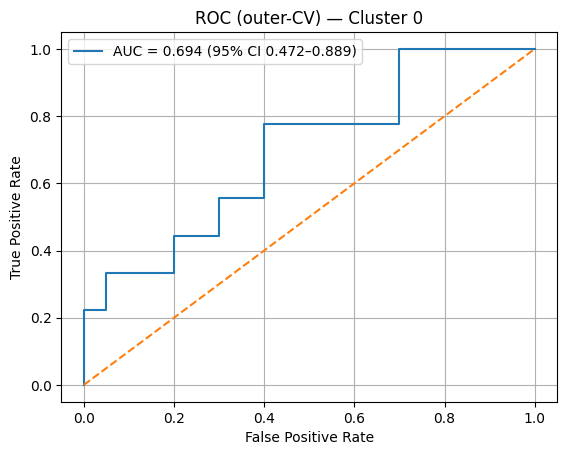

✅ Cluster 0: outer-CV AUC = 0.694 (95% CI 0.472–0.889), 1 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'PTPRC', 'stability_freq': 0.9466666666666667}]

🔍 Cluster 2: matrix (29, 21), 20 genes in dictionary


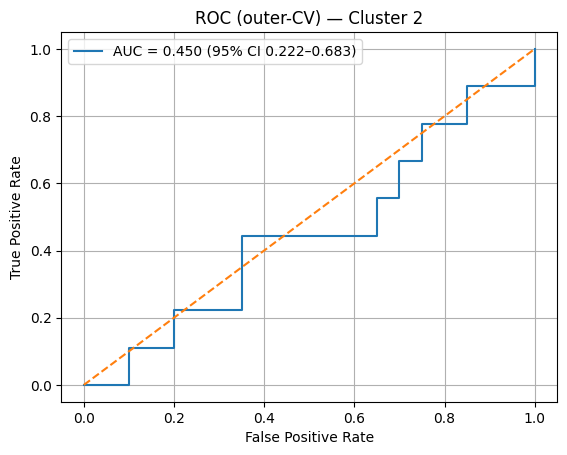

✅ Cluster 2: outer-CV AUC = 0.450 (95% CI 0.222–0.683), 2 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'PFN2', 'stability_freq': 0.6166666666666667}, {'gene': 'LGALS3', 'stability_freq': 0.5966666666666667}, {'gene': 'MGP', 'stability_freq': 0.36333333333333334}, {'gene': 'PERP', 'stability_freq': 0.29333333333333333}, {'gene': 'AZGP1', 'stability_freq': 0.24}, {'gene': 'CD9', 'stability_freq': 0.17}, {'gene': 'CLU', 'stability_freq': 0.16666666666666666}, {'gene': 'KRT7', 'stability_freq': 0.16333333333333333}, {'gene': 'MGST1', 'stability_freq': 0.15333333333333335}, {'gene': 'H2AFJ', 'stability_freq': 0.15}]

🔍 Cluster 3: matrix (29, 3), 2 genes in dictionary


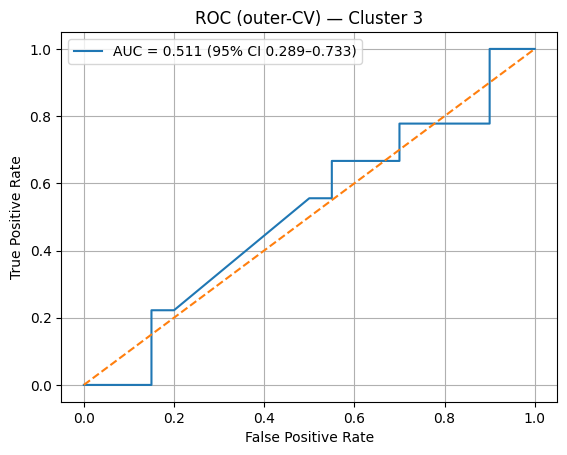

✅ Cluster 3: outer-CV AUC = 0.511 (95% CI 0.289–0.733), 2 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'IL7R', 'stability_freq': 0.7266666666666667}, {'gene': 'LTB', 'stability_freq': 0.6533333333333333}]

🔍 Cluster 4: matrix (29, 2), 1 genes in dictionary


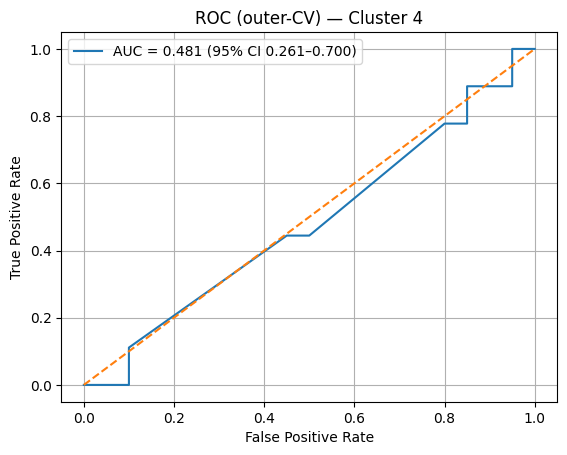

✅ Cluster 4: outer-CV AUC = 0.481 (95% CI 0.261–0.700), 1 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'VAMP5', 'stability_freq': 0.73}]

🔍 Cluster 5: matrix (29, 51), 50 genes in dictionary


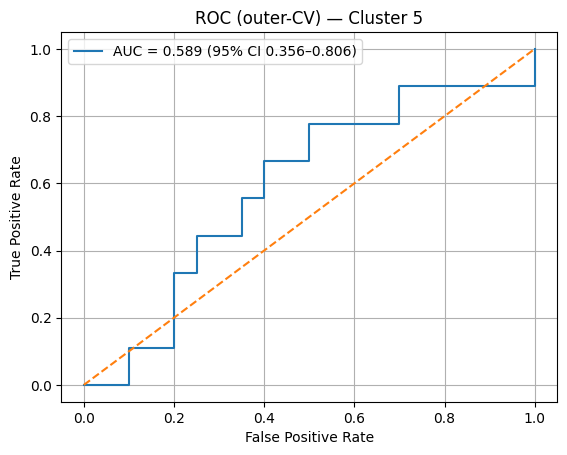

✅ Cluster 5: outer-CV AUC = 0.589 (95% CI 0.356–0.806), 3 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'CXCL14', 'stability_freq': 0.6766666666666667}, {'gene': 'DEGS2', 'stability_freq': 0.5933333333333334}, {'gene': 'TBX3', 'stability_freq': 0.59}, {'gene': 'DSP', 'stability_freq': 0.36000000000000004}, {'gene': 'S100A14', 'stability_freq': 0.35333333333333333}, {'gene': 'DNAJC12', 'stability_freq': 0.29333333333333333}, {'gene': 'ERBB4', 'stability_freq': 0.22333333333333336}, {'gene': 'GAMT', 'stability_freq': 0.19666666666666666}, {'gene': 'PRLR', 'stability_freq': 0.18999999999999997}, {'gene': 'ERBB3', 'stability_freq': 0.16}]

🔍 Cluster 6: matrix (29, 19), 18 genes in dictionary


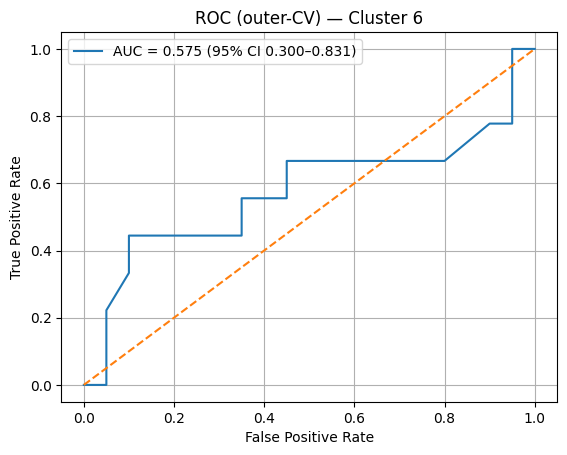

✅ Cluster 6: outer-CV AUC = 0.575 (95% CI 0.300–0.831), 0 stable genes at ≥ 0.4

🔍 Cluster 7: matrix (29, 51), 50 genes in dictionary


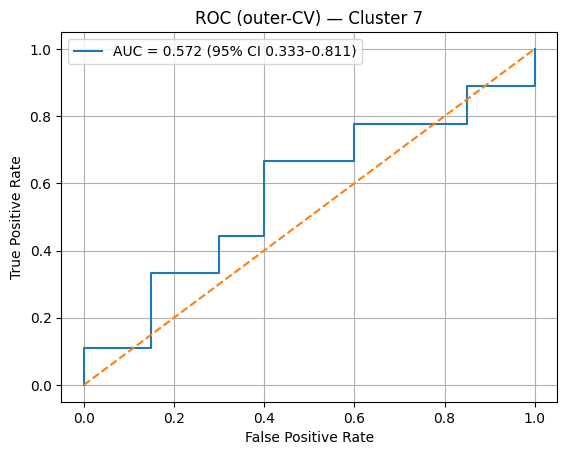

✅ Cluster 7: outer-CV AUC = 0.572 (95% CI 0.333–0.811), 2 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'IL32', 'stability_freq': 0.61}, {'gene': 'CD6', 'stability_freq': 0.5866666666666667}, {'gene': 'PTPN7', 'stability_freq': 0.19666666666666666}, {'gene': 'IL2RG', 'stability_freq': 0.18333333333333335}, {'gene': 'CD8B', 'stability_freq': 0.18000000000000002}, {'gene': 'PSTPIP1', 'stability_freq': 0.17666666666666667}, {'gene': 'PRF1', 'stability_freq': 0.17333333333333334}, {'gene': 'TRBC1', 'stability_freq': 0.16666666666666666}, {'gene': 'APOBEC3G', 'stability_freq': 0.16666666666666666}, {'gene': 'SH2D2A', 'stability_freq': 0.15666666666666665}]

🔍 Cluster 8: matrix (29, 51), 50 genes in dictionary


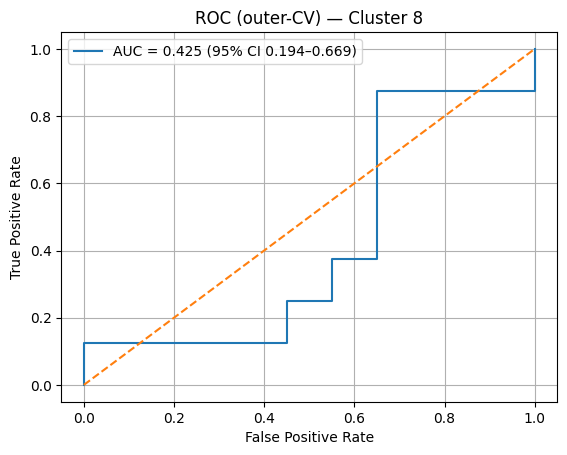

✅ Cluster 8: outer-CV AUC = 0.425 (95% CI 0.194–0.669), 1 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'GAS1', 'stability_freq': 0.44333333333333336}, {'gene': 'COL6A1', 'stability_freq': 0.3933333333333333}, {'gene': 'MMP2', 'stability_freq': 0.3566666666666667}, {'gene': 'FBN1', 'stability_freq': 0.35000000000000003}, {'gene': 'C1QTNF3', 'stability_freq': 0.2933333333333333}, {'gene': 'AEBP1', 'stability_freq': 0.29}, {'gene': 'ADAMTS2', 'stability_freq': 0.25666666666666665}, {'gene': 'PLPP4', 'stability_freq': 0.21666666666666667}, {'gene': 'COL11A1', 'stability_freq': 0.21666666666666667}, {'gene': 'SYNDIG1', 'stability_freq': 0.19666666666666666}]

🔍 Cluster 9: matrix (29, 51), 50 genes in dictionary


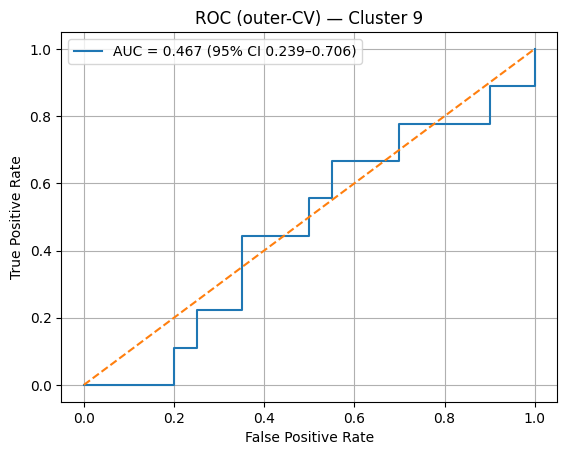

✅ Cluster 9: outer-CV AUC = 0.467 (95% CI 0.239–0.706), 0 stable genes at ≥ 0.4

🔍 Cluster 10: matrix (29, 51), 50 genes in dictionary


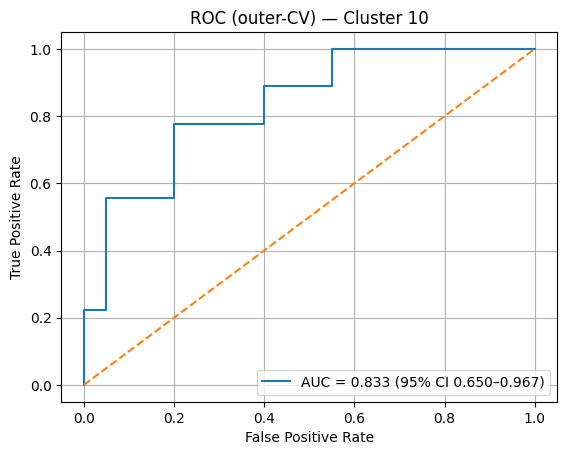

✅ Cluster 10: outer-CV AUC = 0.833 (95% CI 0.650–0.967), 5 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'TREM2', 'stability_freq': 0.7566666666666667}, {'gene': 'HMOX1', 'stability_freq': 0.67}, {'gene': 'CD163', 'stability_freq': 0.6066666666666666}, {'gene': 'PLA2G7', 'stability_freq': 0.45}, {'gene': 'MSR1', 'stability_freq': 0.44333333333333336}, {'gene': 'ADAP2', 'stability_freq': 0.37333333333333335}, {'gene': 'RNASE1', 'stability_freq': 0.36333333333333334}, {'gene': 'C5AR1', 'stability_freq': 0.29}, {'gene': 'IGSF6', 'stability_freq': 0.24666666666666667}, {'gene': 'SIGLEC1', 'stability_freq': 0.24666666666666667}]

🔍 Cluster 11: matrix (29, 51), 50 genes in dictionary


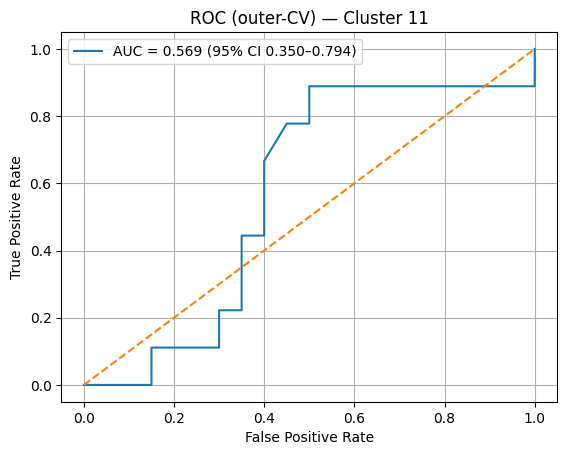

✅ Cluster 11: outer-CV AUC = 0.569 (95% CI 0.350–0.794), 4 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'IGKV1-5', 'stability_freq': 0.7166666666666667}, {'gene': 'IGKV4-1', 'stability_freq': 0.45}, {'gene': 'IGLC2', 'stability_freq': 0.45}, {'gene': 'IGLV6-57', 'stability_freq': 0.41333333333333333}, {'gene': 'IGHG1', 'stability_freq': 0.37666666666666665}, {'gene': 'IGHV3-21', 'stability_freq': 0.3133333333333333}, {'gene': 'SPAG4', 'stability_freq': 0.29}, {'gene': 'IGHV3-23', 'stability_freq': 0.25333333333333335}, {'gene': 'IGHG4', 'stability_freq': 0.21}, {'gene': 'IGLL5', 'stability_freq': 0.20666666666666667}]

🔍 Cluster 12: matrix (29, 51), 50 genes in dictionary


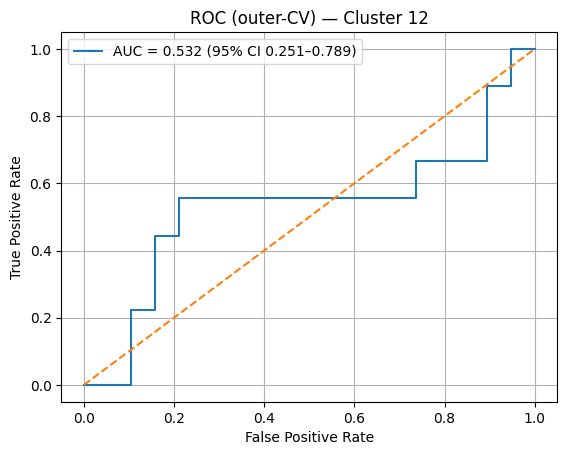

✅ Cluster 12: outer-CV AUC = 0.532 (95% CI 0.251–0.789), 4 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'GZMA', 'stability_freq': 0.59}, {'gene': 'CCL5', 'stability_freq': 0.58}, {'gene': 'CD8A', 'stability_freq': 0.47666666666666674}, {'gene': 'CST7', 'stability_freq': 0.44333333333333336}, {'gene': 'CD7', 'stability_freq': 0.36000000000000004}, {'gene': 'DUSP2', 'stability_freq': 0.29333333333333333}, {'gene': 'EVI2A', 'stability_freq': 0.24666666666666667}, {'gene': 'CCL4L2', 'stability_freq': 0.24333333333333332}, {'gene': 'CCL3', 'stability_freq': 0.20333333333333334}, {'gene': 'TOX', 'stability_freq': 0.19333333333333333}]

🔍 Cluster 13: matrix (29, 51), 50 genes in dictionary


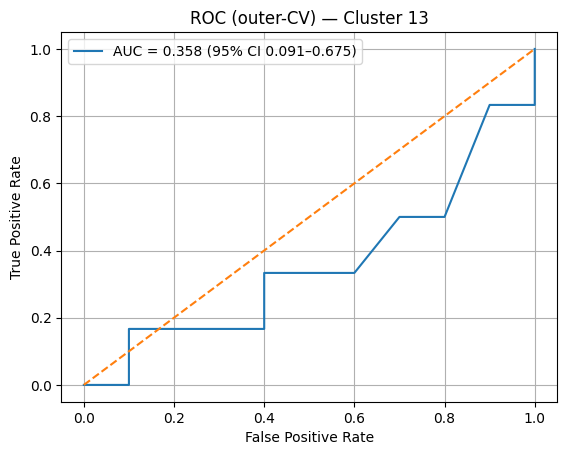

✅ Cluster 13: outer-CV AUC = 0.358 (95% CI 0.091–0.675), 0 stable genes at ≥ 0.4

🔍 Cluster 14: matrix (29, 51), 50 genes in dictionary


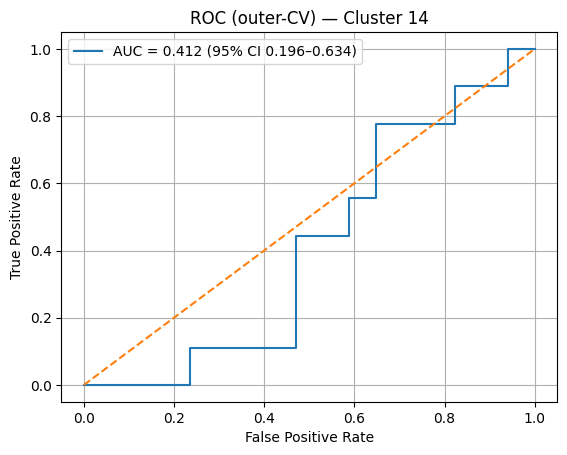

✅ Cluster 14: outer-CV AUC = 0.412 (95% CI 0.196–0.634), 3 stable genes at ≥ 0.4
Top stable genes: [{'gene': 'SELL', 'stability_freq': 0.5433333333333333}, {'gene': 'IKZF1', 'stability_freq': 0.5033333333333333}, {'gene': 'PTPRCAP', 'stability_freq': 0.47666666666666674}, {'gene': 'TMC8', 'stability_freq': 0.32}, {'gene': 'GIMAP7', 'stability_freq': 0.29}, {'gene': 'TRAC', 'stability_freq': 0.26666666666666666}, {'gene': 'RASSF5', 'stability_freq': 0.24666666666666667}, {'gene': 'CXCR4', 'stability_freq': 0.22666666666666668}, {'gene': 'CD52', 'stability_freq': 0.22333333333333336}, {'gene': 'GZMK', 'stability_freq': 0.18666666666666668}]

Summary (conditional bootstrap CI):
 cluster      AUC   CI_low  CI_high  n_stable_genes
      10 0.833333 0.650000 0.966806               5
       0 0.694444 0.472222 0.888889               1
       5 0.588889 0.355556 0.805556               3
       6 0.575000 0.300000 0.830556               0
       7 0.572222 0.333333 0.811250               2
    

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hyperparameter
n_bootstrap_inner = 100
stability_threshold = 0.4
C_grid = [0.001, 0.01, 0.1, 1, 10]
random_seed = 42
use_class_weight_balanced = True

# Helper
def stratified_bootstrap_indices(y, rng):
    y = np.asarray(y)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    boot_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
    boot_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
    return np.concatenate([boot_pos, boot_neg])

def stability_select_on_train(X_train, y_train, C, n_bootstrap=100, thr=0.7, seed=42):
    """Return (selected_idx, freq) using L1-logistic across bootstrap resamples of the training split."""
    rng = np.random.RandomState(seed)
    p = X_train.shape[1]
    counts = np.zeros(p, dtype=float)

    for _ in range(n_bootstrap):
        bidx = stratified_bootstrap_indices(y_train, rng)
        Xb, yb = X_train[bidx], y_train[bidx]
        if np.unique(yb).size < 2:
            continue

        scaler = StandardScaler().fit(Xb)
        Xb = scaler.transform(Xb)

        clf = LogisticRegression(
            penalty="l1", solver="saga", C=C, max_iter=10000,
            class_weight=("balanced" if use_class_weight_balanced else None),
            random_state=seed
        )
        clf.fit(Xb, yb)
        counts += (np.abs(clf.coef_[0]) > 1e-6)

    freq = counts / n_bootstrap
    selected = np.where(freq >= thr)[0]
    return selected, freq

def run_cluster_pipeline(cluster_id, matrix, gene_names, base_seed=42):
    """Nested CV with inner stability selection; returns artifacts for one cluster."""
    X = matrix[:, :-1].astype(float)
    y = matrix[:, -1].astype(int)

    ok = ~np.isnan(X).any(axis=1)
    X, y = X[ok], y[ok]

    if np.unique(y).size < 2 or min(np.bincount(y)) < 2:
        print(f"⚠ Skipping Cluster {cluster_id}: not enough samples per class after filtering.")
        return None

    p = X.shape[1]
    outer = StratifiedKFold(n_splits=3, shuffle=True, random_state=base_seed)

    all_true, all_pred, all_ids = [], [], []
    agg_freq = np.zeros(p, dtype=float)
    n_outer_freq = 0
    chosen_C_list = []

    # Outer loop
    for fold_id, (tr, te) in enumerate(outer.split(X, y)):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        # Inner loop for C and features
        inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=base_seed + fold_id)
        best_auc, best_C, best_sel, best_freq = -np.inf, None, None, None

        for C in C_grid:
            sel_idx, freq = stability_select_on_train(
                X_tr, y_tr, C,
                n_bootstrap=n_bootstrap_inner,
                thr=stability_threshold,
                seed=base_seed
            )
            if sel_idx.size == 0:
                continue

            # score selected features with inner CV
            inner_preds, inner_true = [], []
            for itr, ite in inner.split(X_tr[:, sel_idx], y_tr):
                X_tr2, X_va2 = X_tr[itr][:, sel_idx], X_tr[ite][:, sel_idx]
                y_tr2, y_va2 = y_tr[itr], y_tr[ite]

                scaler = StandardScaler().fit(X_tr2)
                X_tr2 = scaler.transform(X_tr2)
                X_va2 = scaler.transform(X_va2)

                clf = LogisticRegression(
                    penalty="l1", solver="saga", C=C, max_iter=10000,
                    class_weight=("balanced" if use_class_weight_balanced else None),
                    random_state=base_seed
                )
                clf.fit(X_tr2, y_tr2)
                inner_preds.extend(clf.predict_proba(X_va2)[:, 1])
                inner_true.extend(y_va2)

            cv_auc = roc_auc_score(inner_true, inner_preds)
            if cv_auc > best_auc:
                best_auc, best_C, best_sel, best_freq = cv_auc, C, sel_idx, freq

        # Train final model for this outer fold and predict held-out
        if best_sel is None or best_sel.size == 0:
            scaler = StandardScaler().fit(X_tr)
            X_tr2 = scaler.transform(X_tr)
            X_te2 = scaler.transform(X_te)

            clf = LogisticRegression(
                penalty="l2", solver="lbfgs", C=1.0, max_iter=10000,
                class_weight=("balanced" if use_class_weight_balanced else None),
                random_state=base_seed
            )
            clf.fit(X_tr2, y_tr)
            all_pred.extend(clf.predict_proba(X_te2)[:, 1])
            all_true.extend(y_te)
            all_ids.extend(te)
            chosen_C_list.append(None)
        else:
            agg_freq[best_sel] += best_freq[best_sel]
            n_outer_freq += 1
            chosen_C_list.append(best_C)

            scaler = StandardScaler().fit(X_tr[:, best_sel])
            X_tr2 = scaler.transform(X_tr[:, best_sel])
            X_te2 = scaler.transform(X_te[:, best_sel])

            clf = LogisticRegression(
                penalty="l1", solver="saga", C=best_C, max_iter=10000,
                class_weight=("balanced" if use_class_weight_balanced else None),
                random_state=base_seed
            )
            clf.fit(X_tr2, y_tr)
            all_pred.extend(clf.predict_proba(X_te2)[:, 1])
            all_true.extend(y_te)
            all_ids.extend(te)

    df_pred = pd.DataFrame({
        "Sample_ID": all_ids,
        "True_Label": all_true,
        "Predicted_Probability": all_pred
    }).sort_values("Sample_ID").reset_index(drop=True)

    y_true = df_pred["True_Label"].to_numpy()
    y_hat = df_pred["Predicted_Probability"].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_hat)
    auc_point = auc(fpr, tpr)

    mean_freq = agg_freq / n_outer_freq if n_outer_freq > 0 else np.zeros(p, dtype=float)
    stable_table = pd.DataFrame({"gene": gene_names, "stability_freq": mean_freq}) \
                     .sort_values("stability_freq", ascending=False).reset_index(drop=True)
    stable_genes = [gene_names[i] for i in np.where(mean_freq >= stability_threshold)[0]]

    return {
        "df_pred": df_pred,
        "auc": auc_point,
        "fpr": fpr,
        "tpr": tpr,
        "stable_table": stable_table,
        "stable_genes": stable_genes,
        "mean_freq": mean_freq,
        "chosen_C": chosen_C_list
    }

# Estimate AUC confidence intervals using conditional bootstrap
from sklearn.metrics import roc_auc_score

def auc_ci_from_outer_predictions(df_pred, n_boot=2000, alpha=0.05, seed=12345):
    """
    Percentile CI for AUC by stratified bootstrap on (y, p_hat) from outer-CV.
    Conditional on the fitted pipeline (no re-fitting).
    """
    y = df_pred["True_Label"].to_numpy().astype(int)
    p = df_pred["Predicted_Probability"].to_numpy().astype(float)

    point_auc = roc_auc_score(y, p)

    rng = np.random.RandomState(seed)
    pos = np.where(y == 1)[0]
    neg = np.where(y == 0)[0]
    if len(pos) == 0 or len(neg) == 0:
        return {"auc": point_auc, "ci_low": np.nan, "ci_high": np.nan, "boot": np.array([])}

    aucs = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        idx = np.concatenate([
            rng.choice(pos, size=len(pos), replace=True),
            rng.choice(neg, size=len(neg), replace=True)
        ])
        aucs[b] = roc_auc_score(y[idx], p[idx])

    lo, hi = np.percentile(aucs, [100 * (alpha/2), 100 * (1 - alpha/2)])
    return {"auc": point_auc, "ci_low": lo, "ci_high": hi, "boot": aucs}


predicted_outputs_stable_lasso = {}
roc_auc_by_cluster = {}
roc_auc_ci_by_cluster = {}
stable_table_by_cluster = {}
stable_genes_by_cluster = {}
chosen_C_by_cluster = {}

for cluster_id, payload in bulk_data_per_cluster_within_type.items():
    matrix = payload["matrix"]
    genes  = payload["genes"]

    print(f"\n🔍 Cluster {cluster_id}: matrix {matrix.shape}, {len(genes)} genes in dictionary")
    res = run_cluster_pipeline(cluster_id, matrix, genes, base_seed=random_seed)
    if res is None:
        continue

    predicted_outputs_stable_lasso[cluster_id] = res["df_pred"]
    roc_auc_by_cluster[cluster_id] = res["auc"]
    stable_table_by_cluster[cluster_id] = res["stable_table"]
    stable_genes_by_cluster[cluster_id] = res["stable_genes"]
    chosen_C_by_cluster[cluster_id] = res["chosen_C"]

    ci = auc_ci_from_outer_predictions(res["df_pred"], n_boot=2000, alpha=0.05, seed=2024)
    roc_auc_ci_by_cluster[cluster_id] = (ci["ci_low"], ci["ci_high"])

    plt.figure()
    plt.plot(res["fpr"], res["tpr"], label=f"AUC = {res['auc']:.3f} (95% CI {ci['ci_low']:.3f}–{ci['ci_high']:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC (outer-CV) — Cluster {cluster_id}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"✅ Cluster {cluster_id}: outer-CV AUC = {res['auc']:.3f} "
          f"(95% CI {ci['ci_low']:.3f}–{ci['ci_high']:.3f}), "
          f"{len(res['stable_genes'])} stable genes at ≥ {stability_threshold}")
    if len(res["stable_genes"]) > 0:
        print("Top stable genes:", res["stable_table"].head(10).to_dict(orient="records"))

# Results: generate ROC curves and summary tables
summary = pd.DataFrame({
    "cluster": list(roc_auc_by_cluster.keys()),
    "AUC": [roc_auc_by_cluster[k] for k in roc_auc_by_cluster],
    "CI_low": [roc_auc_ci_by_cluster[k][0] for k in roc_auc_by_cluster],
    "CI_high": [roc_auc_ci_by_cluster[k][1] for k in roc_auc_by_cluster],
    "n_stable_genes": [len(stable_genes_by_cluster[k]) for k in roc_auc_by_cluster]
}).sort_values("AUC", ascending=False)
print("\nSummary (conditional bootstrap CI):")
print(summary.to_string(index=False))


# Generate bulk gene expression from I-SPY2 trial dataset

This section reproduces the preprocessing and feature alignment between scMIXE clusters and the I-SPY2 bulk RNA-seq dataset.  

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

val_data_path = "/content/drive/I-SPY2_data.csv"
combined_data = pd.read_csv(val_data_path, index_col=0)

pcr_labels = combined_data.iloc[:, 0].astype(int).values
gene_expr = combined_data.iloc[:, 1:].values

print("Validation gene expression matrix shape:", gene_expr.shape)
print("First few pCR labels:", pcr_labels[:12])

Validation gene expression matrix shape: (988, 19134)
First few pCR labels: [0 0 0 0 0 0 0 0 1 0 1 1]


/tmp/ipython-input-2135488588.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_data = pd.read_csv(val_data_path, index_col=0)


In [ ]:
gene_list_path = "/content/drive/I-SPY2_gene_names.txt"

with open(gene_list_path, "r", encoding="utf-8-sig") as f:
    gene_names = [line.strip().split()[0]
                  for line in f
                  if line.strip() and not line.lstrip().startswith("#")]

print("Total gene names loaded:", len(gene_names))
print("Example gene names:", gene_names[:5])

Total gene names loaded: 19134
Example gene names: ['FAM174B', 'SV2B', 'RBPMS2', 'AVEN', 'PRM1']


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

gene_to_idx = {g: i for i, g in enumerate(gene_names)}

marker_info_per_cluster = {}

for cluster in top_50_per_cluster["cluster"].unique():
    cluster_genes = top_50_per_cluster.loc[
        top_50_per_cluster["cluster"] == cluster, "gene"
    ].tolist()

    indices = [gene_to_idx[g] for g in cluster_genes if g in gene_to_idx]
    missing = [g for g in cluster_genes if g not in gene_to_idx]
    filtered_gene_names = [gene_names[i] for i in indices]

    marker_info_per_cluster[cluster] = {
        "indices": indices,
        "genes": filtered_gene_names,
        "missing": missing
    }

    print(f"Cluster {cluster}: matched {len(indices)} genes; missing {len(missing)}")


Cluster 0: matched 1 genes; missing 0
Cluster 2: matched 20 genes; missing 0
Cluster 3: matched 2 genes; missing 0
Cluster 4: matched 1 genes; missing 0
Cluster 5: matched 45 genes; missing 5
Cluster 6: matched 18 genes; missing 0
Cluster 7: matched 47 genes; missing 3
Cluster 8: matched 48 genes; missing 2
Cluster 9: matched 49 genes; missing 1
Cluster 10: matched 48 genes; missing 2
Cluster 11: matched 23 genes; missing 27
Cluster 12: matched 46 genes; missing 4
Cluster 13: matched 43 genes; missing 7
Cluster 14: matched 47 genes; missing 3


In [ ]:
filtered_data_per_cell_type = {}
for cluster, info in marker_info_per_cluster.items():
    idxs = info["indices"]
    if len(idxs) == 0:
        print(f"⚠ Skipping cluster {cluster}: no matched marker genes.")
        continue

    X_cluster = csr_matrix(gene_expr[:, idxs])
    y = pcr_labels.astype(int).ravel()

    filtered_data_per_cell_type[cluster] = {
        "X": X_cluster,
        "y": y,
        "genes": info["genes"],
        "indices": idxs,
        "missing": info["missing"]
    }

    print(f"✅ Cluster {cluster}: X shape = {X_cluster.shape}, genes saved = {len(info['genes'])}")

✅ Cluster 0: X shape = (988, 1), genes saved = 1
✅ Cluster 2: X shape = (988, 20), genes saved = 20
✅ Cluster 3: X shape = (988, 2), genes saved = 2
✅ Cluster 4: X shape = (988, 1), genes saved = 1
✅ Cluster 5: X shape = (988, 45), genes saved = 45
✅ Cluster 6: X shape = (988, 18), genes saved = 18
✅ Cluster 7: X shape = (988, 47), genes saved = 47
✅ Cluster 8: X shape = (988, 48), genes saved = 48
✅ Cluster 9: X shape = (988, 49), genes saved = 49
✅ Cluster 10: X shape = (988, 48), genes saved = 48
✅ Cluster 11: X shape = (988, 23), genes saved = 23
✅ Cluster 12: X shape = (988, 46), genes saved = 46
✅ Cluster 13: X shape = (988, 43), genes saved = 43
✅ Cluster 14: X shape = (988, 47), genes saved = 47


Restrict to sample who received pembrolizumab + paclitaxel

In [ ]:
clinical_path = '/content/drive/Clinical Table.csv'
clinical_df = pd.read_csv(clinical_path)

In [ ]:
mask = clinical_df["Arm"] == "Paclitaxel + Pembrolizumab"

selected_indices = clinical_df.index[mask].tolist()

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

selected_indices = np.asarray(selected_indices)

filtered_data_per_cell_type_pembro = {}
for cluster, pack in filtered_data_per_cell_type.items():
    X = pack["X"]
    y = pack["y"]
    genes = pack["genes"]

    if selected_indices.dtype == bool:
        if selected_indices.shape[0] != X.shape[0]:
            raise ValueError(f"{cluster}: boolean mask length {selected_indices.shape[0]} "
                             f"!= number of rows {X.shape[0]}")
        rows = np.where(selected_indices)[0]
    else:
        rows = selected_indices.astype(int)

    if rows.max() >= X.shape[0] or rows.min() < 0:
        raise IndexError(f"{cluster}: some selected row indices are out of range")

    X_sub = X[rows, :]
    y_sub = y[rows]

    filtered_data_per_cell_type_pembro[cluster] = {
        "X": X_sub.tocsr(),
        "y": y_sub,
        "genes": list(genes),
        "indices": pack.get("indices", None),
        "missing": pack.get("missing", [])
    }


# Treatment outcome prediction using stabilized LASSO (I-SPY2, 2020)


🔍 Cluster 0: X (69, 1), y (69,)


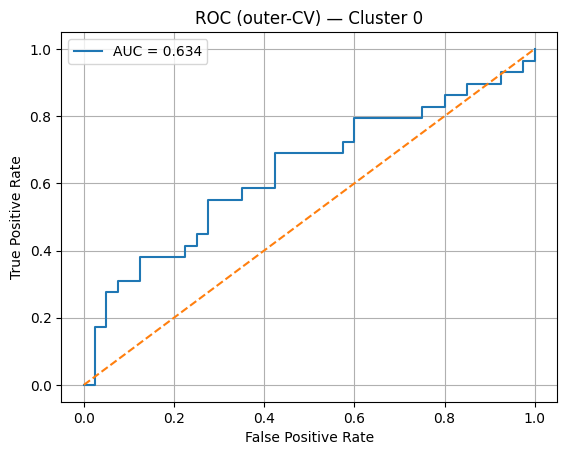

✅ 0: AUC = 0.634, selected-fold AUC = 0.634; stable genes ≥0.65: 1
[{'gene': 'PTPRC', 'stability_freq': 1.0}]

🔍 Cluster 2: X (69, 20), y (69,)


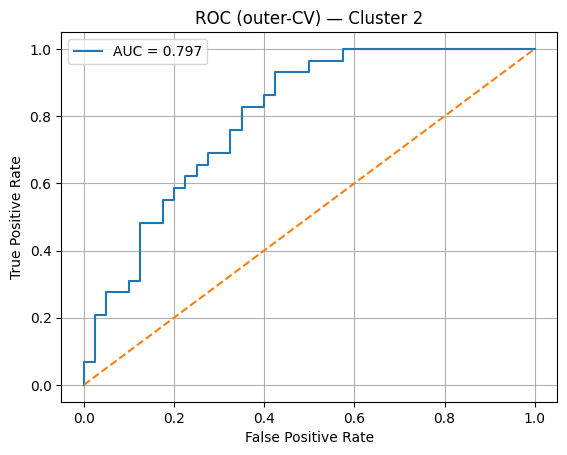

✅ 2: AUC = 0.797, selected-fold AUC = 0.797; stable genes ≥0.65: 7
[{'gene': 'AZGP1', 'stability_freq': 1.0}, {'gene': 'PFN2', 'stability_freq': 0.99}, {'gene': 'CD24', 'stability_freq': 0.898}, {'gene': 'MGP', 'stability_freq': 0.8539999999999999}, {'gene': 'NUPR1', 'stability_freq': 0.754}, {'gene': 'PERP', 'stability_freq': 0.6639999999999999}, {'gene': 'CRNDE', 'stability_freq': 0.662}, {'gene': 'SLPI', 'stability_freq': 0.642}, {'gene': 'CD9', 'stability_freq': 0.48}, {'gene': 'MGST1', 'stability_freq': 0.476}]

🔍 Cluster 3: X (69, 2), y (69,)


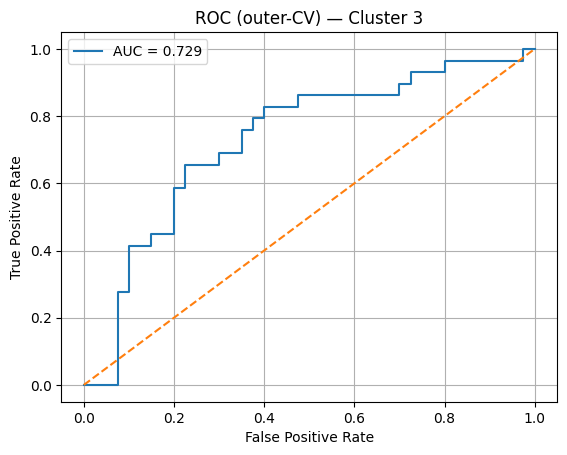

✅ 3: AUC = 0.729, selected-fold AUC = 0.729; stable genes ≥0.65: 2
[{'gene': 'IL7R', 'stability_freq': 1.0}, {'gene': 'LTB', 'stability_freq': 1.0}]

🔍 Cluster 4: X (69, 1), y (69,)


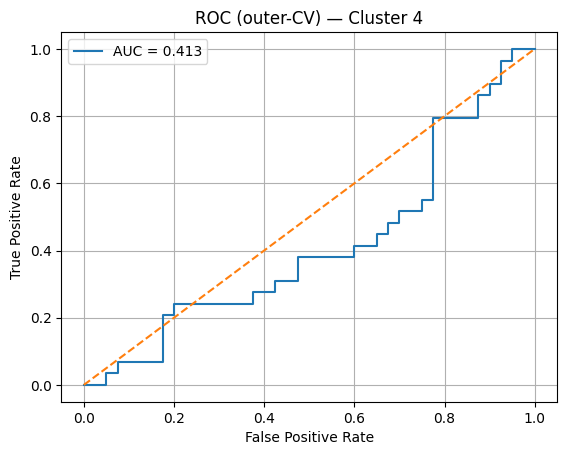

✅ 4: AUC = 0.413, selected-fold AUC = 0.413; stable genes ≥0.65: 1
[{'gene': 'VAMP5', 'stability_freq': 0.8659999999999999}]

🔍 Cluster 5: X (69, 45), y (69,)


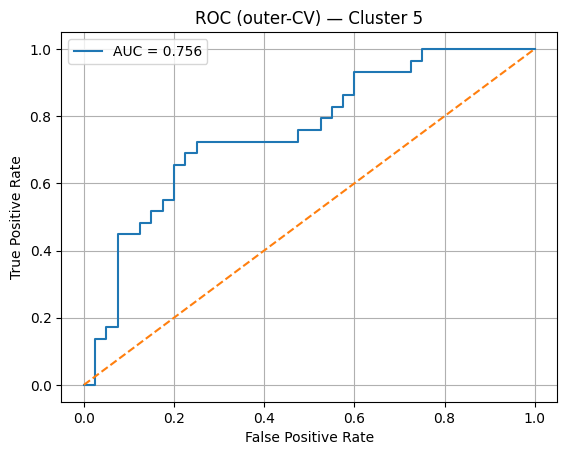

✅ 5: AUC = 0.756, selected-fold AUC = 0.756; stable genes ≥0.65: 10
[{'gene': 'ABHD2', 'stability_freq': 0.942}, {'gene': 'AKR7A3', 'stability_freq': 0.86}, {'gene': 'AGR2', 'stability_freq': 0.8539999999999999}, {'gene': 'TFAP2A', 'stability_freq': 0.85}, {'gene': 'DSP', 'stability_freq': 0.8240000000000001}, {'gene': 'NAT1', 'stability_freq': 0.74}, {'gene': 'PRLR', 'stability_freq': 0.7140000000000001}, {'gene': 'ERBB4', 'stability_freq': 0.6839999999999999}, {'gene': 'RAB25', 'stability_freq': 0.656}, {'gene': 'KRT18', 'stability_freq': 0.65}]

🔍 Cluster 6: X (69, 18), y (69,)


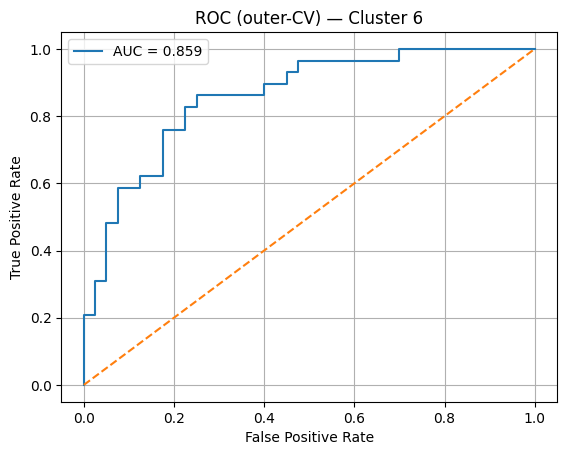

✅ 6: AUC = 0.859, selected-fold AUC = 0.859; stable genes ≥0.65: 2
[{'gene': 'S100A1', 'stability_freq': 0.898}, {'gene': 'CRABP1', 'stability_freq': 0.704}, {'gene': 'PPP1R16A', 'stability_freq': 0.618}, {'gene': 'COL2A1', 'stability_freq': 0.522}, {'gene': 'SNAI2', 'stability_freq': 0.484}, {'gene': 'IGF2', 'stability_freq': 0.46799999999999997}, {'gene': 'CHI3L1', 'stability_freq': 0.466}, {'gene': 'LY6K', 'stability_freq': 0.45600000000000007}, {'gene': 'NPW', 'stability_freq': 0.284}, {'gene': 'CRYAB', 'stability_freq': 0.274}]

🔍 Cluster 7: X (69, 47), y (69,)


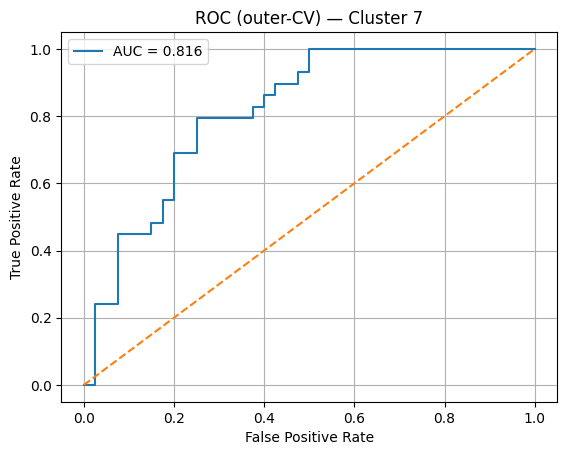

✅ 7: AUC = 0.816, selected-fold AUC = 0.816; stable genes ≥0.65: 6
[{'gene': 'NKG7', 'stability_freq': 0.9960000000000001}, {'gene': 'CD5', 'stability_freq': 0.986}, {'gene': 'CD3E', 'stability_freq': 0.968}, {'gene': 'CTLA4', 'stability_freq': 0.89}, {'gene': 'RGS1', 'stability_freq': 0.876}, {'gene': 'CXCR6', 'stability_freq': 0.7}, {'gene': 'TNFRSF1B', 'stability_freq': 0.45199999999999996}, {'gene': 'CTSW', 'stability_freq': 0.44399999999999995}, {'gene': 'GZMK', 'stability_freq': 0.438}, {'gene': 'APOBEC3G', 'stability_freq': 0.418}]

🔍 Cluster 8: X (69, 48), y (69,)


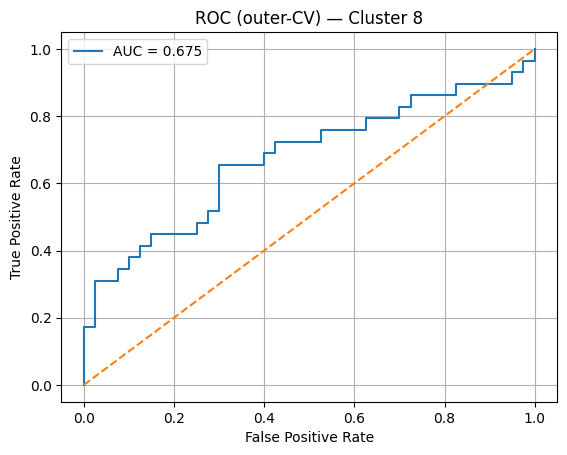

✅ 8: AUC = 0.675, selected-fold AUC = 0.675; stable genes ≥0.65: 6
[{'gene': 'FNDC1', 'stability_freq': 0.9540000000000001}, {'gene': 'FBN1', 'stability_freq': 0.9359999999999999}, {'gene': 'COL1A1', 'stability_freq': 0.9119999999999999}, {'gene': 'ADAMTS2', 'stability_freq': 0.8560000000000001}, {'gene': 'COL12A1', 'stability_freq': 0.8440000000000001}, {'gene': 'THBS2', 'stability_freq': 0.7939999999999999}, {'gene': 'GAS1', 'stability_freq': 0.6239999999999999}, {'gene': 'COL1A2', 'stability_freq': 0.62}, {'gene': 'HMCN1', 'stability_freq': 0.496}, {'gene': 'ASPN', 'stability_freq': 0.458}]

🔍 Cluster 9: X (69, 49), y (69,)


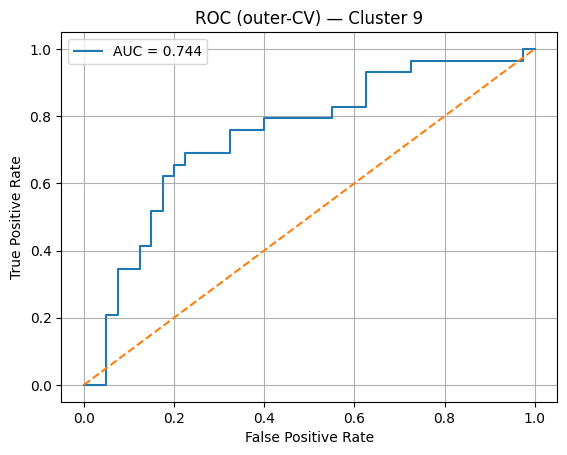

✅ 9: AUC = 0.744, selected-fold AUC = 0.744; stable genes ≥0.65: 6
[{'gene': 'C1QA', 'stability_freq': 0.9720000000000001}, {'gene': 'HLA-DPA1', 'stability_freq': 0.932}, {'gene': 'CYBB', 'stability_freq': 0.916}, {'gene': 'MARCH1', 'stability_freq': 0.8899999999999999}, {'gene': 'CD74', 'stability_freq': 0.85}, {'gene': 'IGSF6', 'stability_freq': 0.8379999999999999}, {'gene': 'MPEG1', 'stability_freq': 0.63}, {'gene': 'IRF8', 'stability_freq': 0.596}, {'gene': 'HLA-DPB1', 'stability_freq': 0.516}, {'gene': 'LYZ', 'stability_freq': 0.492}]

🔍 Cluster 10: X (69, 48), y (69,)


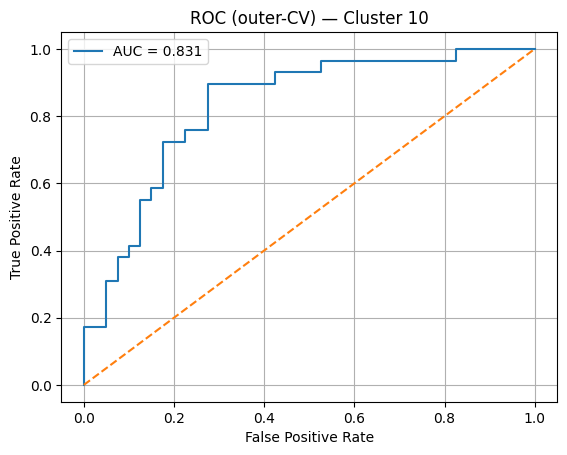

✅ 10: AUC = 0.831, selected-fold AUC = 0.831; stable genes ≥0.65: 7
[{'gene': 'GPR34', 'stability_freq': 0.974}, {'gene': 'PLA2G7', 'stability_freq': 0.9720000000000001}, {'gene': 'PILRA', 'stability_freq': 0.9419999999999998}, {'gene': 'C1QA', 'stability_freq': 0.8939999999999999}, {'gene': 'CD163', 'stability_freq': 0.884}, {'gene': 'HMOX1', 'stability_freq': 0.78}, {'gene': 'MSR1', 'stability_freq': 0.6639999999999999}, {'gene': 'CSF1R', 'stability_freq': 0.5359999999999999}, {'gene': 'CCL2', 'stability_freq': 0.47400000000000003}, {'gene': 'IGSF6', 'stability_freq': 0.43800000000000006}]

🔍 Cluster 11: X (69, 23), y (69,)


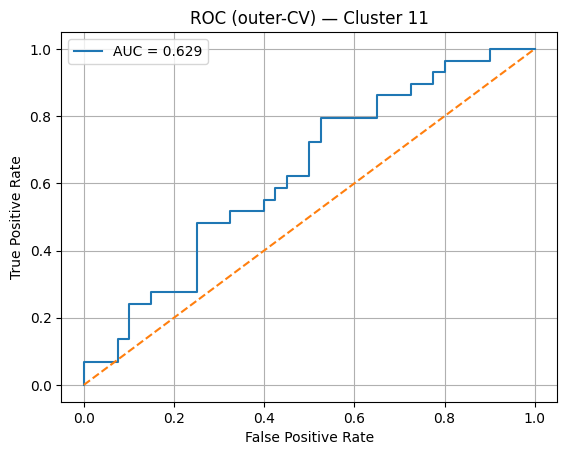

✅ 11: AUC = 0.629, selected-fold AUC = 0.629; stable genes ≥0.65: 9
[{'gene': 'HERPUD1', 'stability_freq': 0.834}, {'gene': 'PDK1', 'stability_freq': 0.8160000000000001}, {'gene': 'SSR4', 'stability_freq': 0.8099999999999999}, {'gene': 'MZB1', 'stability_freq': 0.806}, {'gene': 'TXNDC5', 'stability_freq': 0.774}, {'gene': 'TXNDC11', 'stability_freq': 0.75}, {'gene': 'PRDX4', 'stability_freq': 0.72}, {'gene': 'FKBP11', 'stability_freq': 0.7140000000000001}, {'gene': 'SPAG4', 'stability_freq': 0.682}, {'gene': 'EAF2', 'stability_freq': 0.612}]

🔍 Cluster 12: X (69, 46), y (69,)


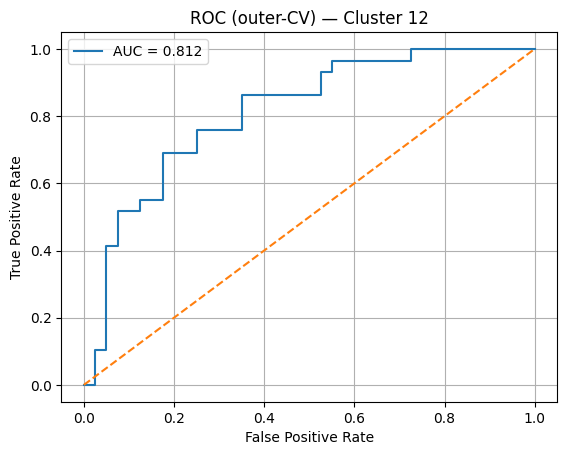

✅ 12: AUC = 0.812, selected-fold AUC = 0.812; stable genes ≥0.65: 8
[{'gene': 'NKG7', 'stability_freq': 1.0}, {'gene': 'TOX', 'stability_freq': 0.836}, {'gene': 'CD200', 'stability_freq': 0.8219999999999998}, {'gene': 'PTPN7', 'stability_freq': 0.808}, {'gene': 'CTLA4', 'stability_freq': 0.78}, {'gene': 'PDCD1', 'stability_freq': 0.77}, {'gene': 'CXCR6', 'stability_freq': 0.692}, {'gene': 'APOBEC3G', 'stability_freq': 0.662}, {'gene': 'SLA', 'stability_freq': 0.612}, {'gene': 'IFNG', 'stability_freq': 0.49399999999999994}]

🔍 Cluster 13: X (69, 43), y (69,)


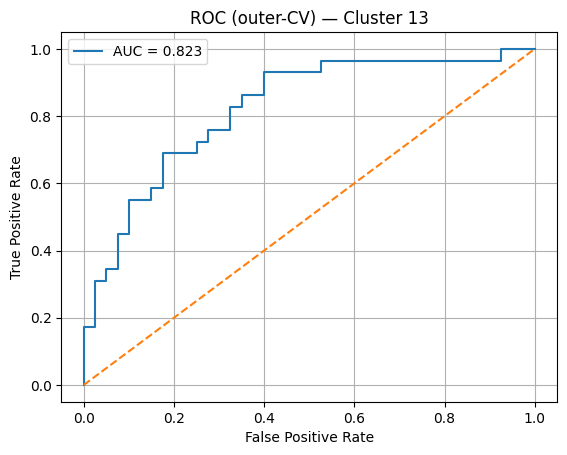

✅ 13: AUC = 0.823, selected-fold AUC = 0.823; stable genes ≥0.65: 4
[{'gene': 'RAPGEFL1', 'stability_freq': 1.0}, {'gene': 'CRMP1', 'stability_freq': 0.916}, {'gene': 'SERINC2', 'stability_freq': 0.8540000000000001}, {'gene': 'ERLIN2', 'stability_freq': 0.728}, {'gene': 'MDM2', 'stability_freq': 0.5880000000000001}, {'gene': 'PDZK1', 'stability_freq': 0.454}, {'gene': 'ADORA1', 'stability_freq': 0.44800000000000006}, {'gene': 'MSMB', 'stability_freq': 0.446}, {'gene': 'PVALB', 'stability_freq': 0.434}, {'gene': 'TINCR', 'stability_freq': 0.32799999999999996}]

🔍 Cluster 14: X (69, 47), y (69,)


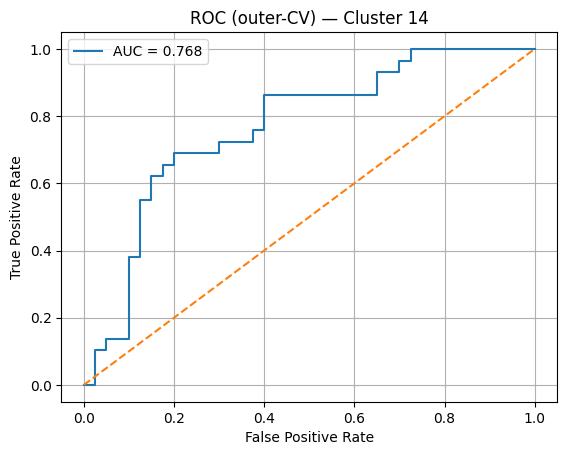

✅ 14: AUC = 0.768, selected-fold AUC = 0.768; stable genes ≥0.65: 5
[{'gene': 'NKG7', 'stability_freq': 0.998}, {'gene': 'IL7R', 'stability_freq': 0.9399999999999998}, {'gene': 'CD3E', 'stability_freq': 0.9359999999999999}, {'gene': 'RASSF5', 'stability_freq': 0.8140000000000001}, {'gene': 'CTSW', 'stability_freq': 0.7939999999999999}, {'gene': 'STK17A', 'stability_freq': 0.586}, {'gene': 'CD69', 'stability_freq': 0.574}, {'gene': 'SIT1', 'stability_freq': 0.47800000000000004}, {'gene': 'GZMK', 'stability_freq': 0.42400000000000004}, {'gene': 'CD52', 'stability_freq': 0.328}]


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hyperparameter
outer_folds = 5
inner_folds = 5
n_bootstrap_inner = 100
stability_threshold = 0.65
C_grid = [0.01, 0.1, 1, 10]
use_class_weight_balanced = False
random_seed = 42


# Helpers
def stratified_bootstrap_indices(y, rng):
    y = np.asarray(y)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    boot_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
    boot_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
    return np.concatenate([boot_pos, boot_neg])

def fit_scaler_for(X):
    if sparse.issparse(X):
        return StandardScaler(with_mean=False).fit(X)
    else:
        return StandardScaler().fit(X)

def transform_with(scaler, X):
    return scaler.transform(X)

def stability_select_on_train(X_train, y_train, C, n_bootstrap=100, thr=0.5, seed=42):
    """Run L1-logistic across bootstrap resamples of the training split and return (selected_idx, freq)."""
    rng = np.random.RandomState(seed)
    p = X_train.shape[1]
    counts = np.zeros(p, dtype=float)

    for _ in range(n_bootstrap):
        bidx = stratified_bootstrap_indices(y_train, rng)
        Xb, yb = X_train[bidx], y_train[bidx]
        if np.unique(yb).size < 2:
            continue

        scaler = fit_scaler_for(Xb)
        Xb = transform_with(scaler, Xb)

        clf = LogisticRegression(
            penalty="l1", solver="saga", C=C, max_iter=10000,
            class_weight=("balanced" if use_class_weight_balanced else None),
            random_state=seed
        )
        clf.fit(Xb, yb)
        counts += (np.abs(clf.coef_[0]) > 1e-6)

    freq = counts / n_bootstrap
    selected = np.where(freq >= thr)[0]
    return selected, freq

def run_cluster_pipeline(cluster_id, X, y, genes, base_seed=42):
    if sparse.issparse(X):
        X = X.tocsr()
        if np.isnan(X.data).any():
            raise ValueError(f"{cluster_id}: NaNs in sparse X.data are not supported")
    else:
        ok = ~np.isnan(X).any(axis=1)
        X, y = X[ok], y[ok]

    y = y.astype(int)
    if np.unique(y).size < 2 or min(np.bincount(y)) < 2 or len(y) < outer_folds:
        print(f"⚠ Skipping {cluster_id}: insufficient class counts for {outer_folds}-fold CV.")
        return None

    p = X.shape[1]
    outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=base_seed)

    all_true, all_pred, all_ids = [], [], []
    agg_freq = np.zeros(p, dtype=float)
    n_outer_freq = 0
    chosen_C_list = []
    fold_kind = []

    for fold_id, (tr, te) in enumerate(outer.split(X, y)):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=base_seed + fold_id)
        best_auc, best_C, best_sel, best_freq = -np.inf, None, None, None

        for C in C_grid:
            sel_idx, freq = stability_select_on_train(
                X_tr, y_tr, C,
                n_bootstrap=n_bootstrap_inner,
                thr=stability_threshold,
                seed=base_seed
            )
            if sel_idx.size == 0:
                continue

            inner_preds, inner_true = [], []
            X_tr_sel = X_tr[:, sel_idx]
            for itr, ite in inner.split(X_tr_sel, y_tr):
                X_tr2, X_va2 = X_tr_sel[itr], X_tr_sel[ite]
                y_tr2, y_va2 = y_tr[itr], y_tr[ite]

                scaler = fit_scaler_for(X_tr2)
                X_tr2 = transform_with(scaler, X_tr2)
                X_va2 = transform_with(scaler, X_va2)

                clf = LogisticRegression(
                    penalty="l1", solver="saga", C=C, max_iter=10000,
                    class_weight=("balanced" if use_class_weight_balanced else None),
                    random_state=base_seed
                )
                clf.fit(X_tr2, y_tr2)
                inner_preds.extend(clf.predict_proba(X_va2)[:, 1])
                inner_true.extend(y_va2)

            cv_auc = roc_auc_score(inner_true, inner_preds)
            if cv_auc > best_auc:
                best_auc, best_C, best_sel, best_freq = cv_auc, C, sel_idx, freq

        if best_sel is None or best_sel.size == 0:
            scaler = fit_scaler_for(X_tr)
            X_tr2 = transform_with(scaler, X_tr)
            X_te2 = transform_with(scaler, X_te)

            clf = LogisticRegression(
                penalty="l2", solver="lbfgs", C=1.0, max_iter=10000,
                class_weight=("balanced" if use_class_weight_balanced else None),
                random_state=base_seed
            )
            clf.fit(X_tr2, y_tr)
            preds = clf.predict_proba(X_te2)[:, 1]
            all_pred.extend(preds); all_true.extend(y_te); all_ids.extend(te)
            fold_kind.extend(["fallback"] * len(y_te))
            chosen_C_list.append(None)
        else:
            agg_freq[best_sel] += best_freq[best_sel]
            n_outer_freq += 1
            chosen_C_list.append(best_C)

            X_tr_sel = X_tr[:, best_sel]
            X_te_sel = X_te[:, best_sel]
            scaler = fit_scaler_for(X_tr_sel)
            X_tr2 = transform_with(scaler, X_tr_sel)
            X_te2 = transform_with(scaler, X_te_sel)

            clf = LogisticRegression(
                penalty="l1", solver="saga", C=best_C, max_iter=10000,
                class_weight=("balanced" if use_class_weight_balanced else None),
                random_state=base_seed
            )
            clf.fit(X_tr2, y_tr)
            preds = clf.predict_proba(X_te2)[:, 1]
            all_pred.extend(preds); all_true.extend(y_te); all_ids.extend(te)
            fold_kind.extend(["selected"] * len(y_te))

    df_pred = pd.DataFrame({
        "Sample_ID": all_ids,
        "True_Label": all_true,
        "Predicted_Probability": all_pred,
        "FoldKind": fold_kind
    }).sort_values("Sample_ID").reset_index(drop=True)

    y_true = df_pred["True_Label"].to_numpy()
    y_hat  = df_pred["Predicted_Probability"].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_hat)
    auc_point = auc(fpr, tpr)

    mean_freq = agg_freq / n_outer_freq if n_outer_freq > 0 else np.zeros(p, dtype=float)
    stable_table = pd.DataFrame({"gene": genes, "stability_freq": mean_freq}) \
                     .sort_values("stability_freq", ascending=False).reset_index(drop=True)
    stable_genes = [genes[i] for i in np.where(mean_freq >= stability_threshold)[0]]

    auc_selected_only = None
    auc_fallback_only = None
    if (df_pred["FoldKind"] == "selected").any():
        d = df_pred[df_pred["FoldKind"] == "selected"]
        auc_selected_only = roc_auc_score(d["True_Label"], d["Predicted_Probability"])
    if (df_pred["FoldKind"] == "fallback").any():
        d = df_pred[df_pred["FoldKind"] == "fallback"]
        auc_fallback_only = roc_auc_score(d["True_Label"], d["Predicted_Probability"])

    return {
        "df_pred": df_pred,
        "auc": auc_point,
        "fpr": fpr, "tpr": tpr,
        "stable_table": stable_table,
        "stable_genes": stable_genes,
        "mean_freq": mean_freq,
        "chosen_C": chosen_C_list,
        "auc_selected_only": auc_selected_only,
        "auc_fallback_only": auc_fallback_only
    }


predicted_outputs_lasso_tuned = {}
roc_auc_by_cell = {}
stable_table_by_cell = {}
stable_genes_by_cell = {}
chosen_C_by_cell = {}

for cell_type, pack in filtered_data_per_cell_type_pembro.items():
    X = pack["X"]
    y = pack["y"]
    genes = pack["genes"]

    print(f"\n🔍 Cluster {cell_type}: X {X.shape}, y {y.shape}")
    res = run_cluster_pipeline(cell_type, X, y, genes, base_seed=random_seed)
    if res is None:
        continue

    predicted_outputs_lasso_tuned[cell_type] = res["df_pred"]
    roc_auc_by_cell[cell_type] = res["auc"]
    stable_table_by_cell[cell_type] = res["stable_table"]
    stable_genes_by_cell[cell_type] = res["stable_genes"]
    chosen_C_by_cell[cell_type] = res["chosen_C"]

    plt.figure()
    plt.plot(res["fpr"], res["tpr"], label=f"AUC = {res['auc']:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC (outer-CV) — Cluster {cell_type}")
    plt.legend()
    plt.grid(True)
    plt.show()

    msg = f"AUC = {res['auc']:.3f}"
    if res["auc_selected_only"] is not None:
        msg += f", selected-fold AUC = {res['auc_selected_only']:.3f}"
    if res["auc_fallback_only"] is not None:
        msg += f", fallback-fold AUC = {res['auc_fallback_only']:.3f}"
    print(f"✅ {cell_type}: {msg}; stable genes ≥{stability_threshold}: {len(res['stable_genes'])}")
    if len(res["stable_genes"]) > 0:
        print(res["stable_table"].head(10).to_dict(orient="records"))
